# Convolutional Neural Networks

---

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  

The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.

There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

## The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm


---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import wget

def download_and_install(dir_name, url, file_name):
    if not os.path.exists('data/{}'.format(dir_name)):
        print('Downloading dataset in dir data/{}'.format(dir_name))
        wget.download(url, file_name)
        !unzip dogImages.zip
    else:
        print('Found dataset dir data/{}'.format(dir_name))
    
# Check if the dataset is present, otherwise download it

download_and_install(
    'dogImages', 
    'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip', 
    'data/dogImages.zip')

download_and_install(
    'lfw', 
    'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip', 
    'data/lfw.zip')


Found dataset dir data/dogImages
Found dataset dir data/lfw


In [2]:
import numpy as np
from glob import glob
import requests

# Get imagenet class names
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

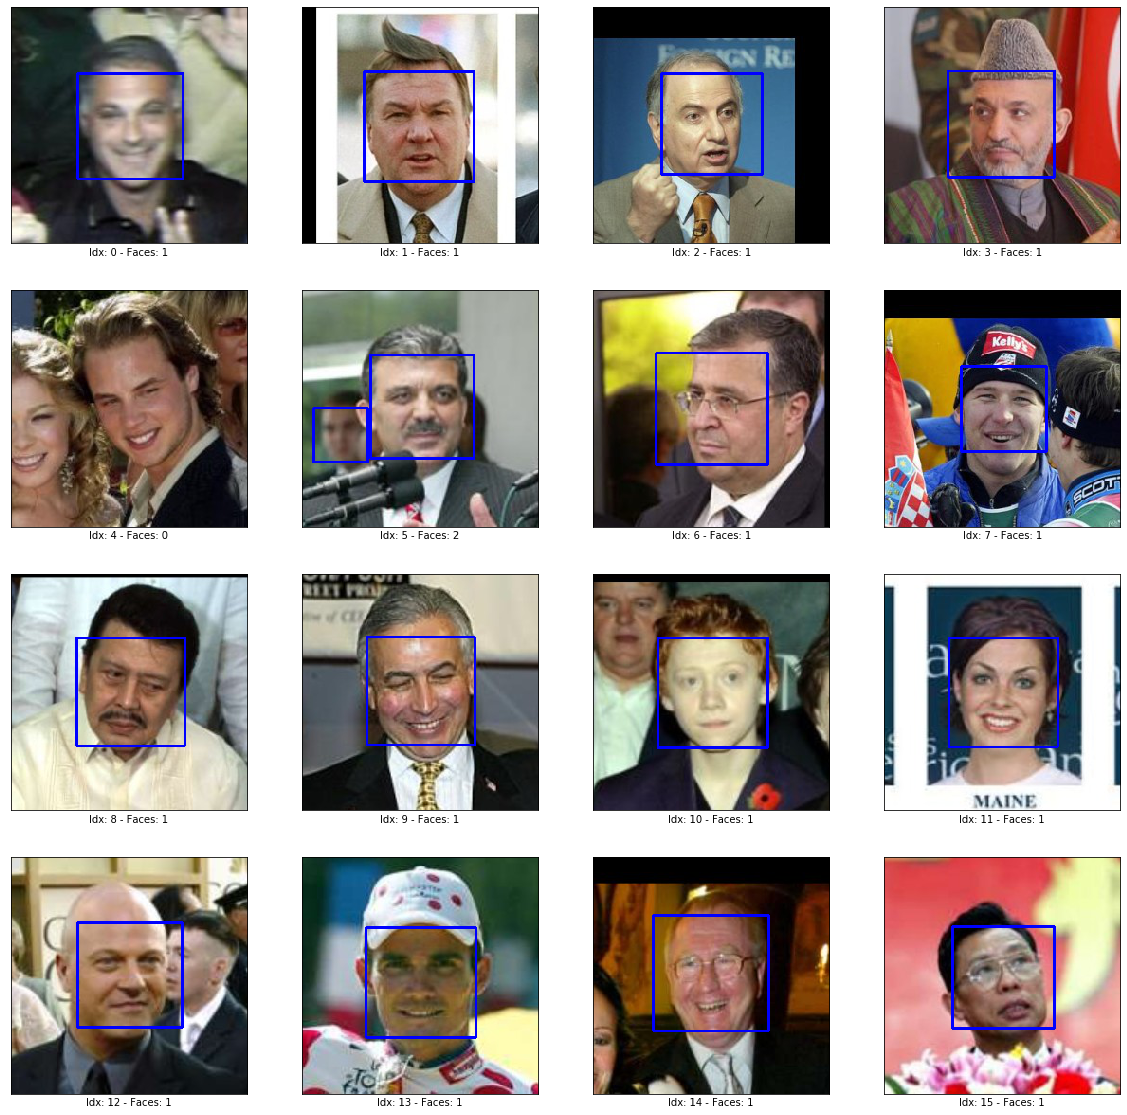

In [3]:
import cv2                
import matplotlib.pyplot as plt   
from random import random
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def load_random_image():
    
    # load color (BGR) image
    img = cv2.imread(human_files[int(random() * len(human_files))])

    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    #print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), len(faces)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 20))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(4, plot_size/4, idx+1, xticks=[], yticks=[])
    img, faces = load_random_image()
    plt.xlabel("Idx: {} - Faces: {}".format(idx, faces))
    plt.imshow(img)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ Using the *Haar feature-based cascade classifier* model named haarcascade_frontalface_alt, on the first 100 samples of both the dataset, the detection performance are:
- 99% for the `human_files` image set
- 9% for the `dog_files` image set

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def faces_detec_test(images):
    
    faces_detected = 0.0
    total_images = len(images)
    
    for image in images:
        if face_detector(image):
            faces_detected += 1
        
    return faces_detected, total_images
    
print('Cascade \'haarcascade_frontalface_alt\' classifier performance')

faces_detected, total_images = faces_detec_test(human_files_short)
print('  - Humans faces detected: {:.0f}%'.format(faces_detected * 100 / total_images))

dog_detected, total_images = faces_detec_test(dog_files_short)
print('  - Dogs detected: {:.0f}%'.format(dog_detected * 100 / total_images))

Cascade 'haarcascade_frontalface_alt' classifier performance
  - Humans faces detected: 99%
  - Dogs detected: 9%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

# Define another pre-trained face detector
face_cascade2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

# returns "True" if face is detected in image stored at img_path
def face_detector2(img_path):
    img2 = cv2.imread(img_path)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    faces = face_cascade2.detectMultiScale(gray2)
    return len(faces) > 0

def face_detector2_test(images):
    
    faces_detected = 0.0
    total_images = len(images)
    
    for image in images:
        if face_detector2(image):
            faces_detected += 1
        
    return faces_detected, total_images
    
print('Cascade \'haarcascade_frontalface_alt2\' classifier performance')

faces_detected, total_images = face_detector2_test(human_files_short)
print('  - Humans faces detected: {:.0f}%'.format(faces_detected * 100 / total_images))

dog_detected, total_images = face_detector2_test(dog_files_short)
print('  - Dogs detected: {:.0f}%'.format(dog_detected * 100 / total_images))

Cascade 'haarcascade_frontalface_alt2' classifier performance
  - Humans faces detected: 100%
  - Dogs detected: 16%


__Answer__: Using the *Haar feature-based cascade classifier* model named haarcascade_frontalface_alt2, on the first 100 samples of both the dataset, the detection performance are:
- 100% for the `human_files` image set
- 16% for the `dog_files` image set

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [8]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    print("Cuda available!")
    VGG16 = VGG16.cuda()
else:
    print("No CUDA available!")

No CUDA available!


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

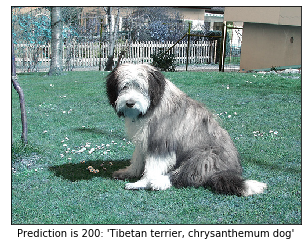

In [9]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    
    ## Load and pre-process an image from the given img_path
    # All pre-trained models accept image formatted as:
    #   - 3 channels RGB images of shape 3 x H x V
    #   - H and V should be 224 pixels
    #   - Loaded in the range og [0, 1] and normalized with given parameters
    img = Image.open(img_path).convert('RGB')
    
    # Resize and Normalization transformation
    prepare_images = transforms.Compose([
            transforms.Resize(size=(244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])
    
    # Apply the transformation, discard the Alpha channle (:3), and add the batch dimension
    img = prepare_images(img)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
        
    # Returns a Tensor of shape (batch, num class labels)
    model_output = VGG16(img)
    
    # Convert model output => predicted class
    _, preds_tensor = torch.max(model_output, 1)
    
    return np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

random_index = int(random() * len(dog_files))
       
prediction = VGG16_predict(dog_files[random_index])

# load color (BGR) image
img = cv2.imread(dog_files[random_index])

# display the image, along with bounding box
plt.figure()
plt.imshow(img)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Prediction is {}: \'{}\'".format(prediction, labels[int(prediction)]))
plt.show()


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    ## TODO: Complete the function.
    class_index = VGG16_predict(img_path)
    
    if (class_index >= 151) and (class_index <= 268):
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ Using the pre-trained *VGG16* classifier on the first 100 samples of both the dataset, the detection performance are:
- 100% for the `human_files` image set
- 100% for the `dog_files` image set


In [11]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def dog_detec_test(images):
    
    dog_detected = 0.0
    total_images = len(images)
    
    for image in images:
        if dog_detector(image):
            dog_detected += 1
        
    return dog_detected, total_images

print('\'VGG-16\' pre-trained classifier performance')

dog_detected, total_images = dog_detec_test(human_files_short)
print('  - Humans faces detected: {:.0f}%'.format(faces_detected * 100 / total_images))

dog_detected, total_images = dog_detec_test(dog_files_short)
print('  - Dogs detected: {:.0f}%'.format(dog_detected * 100 / total_images))


'VGG-16' pre-trained classifier performance
  - Humans faces detected: 100%
  - Dogs detected: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

In [13]:
# Import the RESNET pre-trained model
RESNET18 = models.resnet18(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    print("Cuda available!")
    RESNET18 = RESNET18.cuda()
else:
    print("No CUDA available!")

No CUDA available!


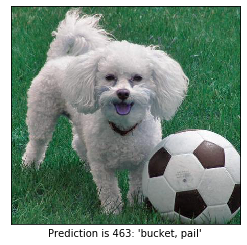

In [14]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

def RESNET18_predict(img_path):
    '''
    Use pre-trained RESNET18 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to RESNET18 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    # All pre-trained models accept image formatted as:
    #   - 3 channels RGB images of shape 3 x H x V
    #   - H and V should be 224 pixels
    #   - Loaded in the range og [0, 1] and normalized with given parameters
    img = Image.open(img_path).convert('RGB')
    
    # Resize and Normalization transformation
    prepare_images = transforms.Compose([
            transforms.Resize(size=(244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])
    
    # Apply the transformation, discard the Alpha channle (:3), and add the batch dimension
    img = prepare_images(img)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
        
    # Returns a Tensor of shape (batch, num class labels)
    model_output = RESNET18(img)
    
    # Convert model output => predicted class
    _, preds_tensor = torch.max(model_output, 1)
    
    return np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

random_index = int(random() * len(dog_files))
       
prediction = RESNET18_predict(dog_files[random_index])

# load color (BGR) image
img = cv2.imread(dog_files[random_index])

# display the image, along with bounding box
plt.figure()
plt.imshow(img)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Prediction is {}: \'{}\'".format(prediction, labels[int(prediction)]))
plt.show()


In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_RESNET(img_path):
    
    ## TODO: Complete the function.
    class_index = RESNET18_predict(img_path)
    
    if (class_index >= 151) and (class_index <= 268):
        return True
    else:
        return False

In [16]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def dog_detec_test_RESNET(images):
    
    dog_detected = 0.0
    total_images = len(images)
    
    for image in images:
        if dog_detector_RESNET(image):
            dog_detected += 1
        
    return dog_detected, total_images

print('\'RESNET18\' pre-trained classifier performance')

dog_detected, total_images = dog_detec_test(human_files_short)
print('  - Humans faces detected: {:.0f}%'.format(faces_detected * 100 / total_images))

dog_detected, total_images = dog_detec_test(dog_files_short)
print('  - Dogs detected: {:.0f}%'.format(dog_detected * 100 / total_images))


'RESNET18' pre-trained classifier performance
  - Humans faces detected: 100%
  - Dogs detected: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
 - | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
import os
from torchvision import datasets
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Define the number of samples loaded in one batch
batch_size = 40

# Number of processes to be used
num_workers = 0

# Define trasforms to be used for every set
base_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = {
    'train' : transforms.Compose([transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(25),
                                  transforms.RandomResizedCrop(224),
                                  transforms.ToTensor(),
                                  base_normalization]),
    'valid' : transforms.Compose([transforms.Resize(260),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  base_normalization]),
    'test' :  transforms.Compose([transforms.Resize(size=(244, 244)),
                                  transforms.ToTensor(),
                                  base_normalization])
}    

# Define Image Folder for train, test and validate dataset
base_dir = 'data/dogImages/'

# Create image dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), transform[x])
                  for x in ['train', 'valid', 'test']}

# Create data loaders
loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'valid', 'test']}

In [18]:
# Print some basic information about datasets
print('Numbers of images')
print('  - training dataset:   {}'.format(len(image_datasets['train'])))
print('  - validation dataset: {}'.format(len(image_datasets['valid'])))
print('  - testing dataset:    {}'.format(len(image_datasets['test'])))
print('Numbers of classes')
print('  - training dataset:   {}'.format(len(image_datasets['train'].classes)))
print('  - validation dataset: {}'.format(len(image_datasets['valid'].classes)))
print('  - testing dataset:    {}'.format(len(image_datasets['test'].classes)))

Numbers of images
  - training dataset:   6680
  - validation dataset: 835
  - testing dataset:    836
Numbers of classes
  - training dataset:   133
  - validation dataset: 133
  - testing dataset:    133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

I have applied the same required normalization and final size of 224 to all the dataset, as described in the pytorch documentation.

I have defined different resize for *train*, *test* and *valid* dataset:
  - **Train**: Random *Resize* and *Crop* to 224
  - **Validate**: Fixed *Resize* to 260 and then *Center Crop* to 224
  - **Test**: Only Fixed *Resize* to to 224
  
I have decided to add some degree of data augmentation, inserting random *Resize*, *Rotation* and *Flip* to training data, for prevent overfitting and obtain a more robust model.

This is not need to do that for the validation data, or the test data, so I have just added resize and center crop or only resize to them.  

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    ### TODO: choose an architecture, and complete the class

    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # Convolutional Layer
        self.conv1_1 = nn.Conv2d(  3, 64,3,1,1)
        self.conv2_1 = nn.Conv2d( 64, 64,3,1,1)
        self.conv3_1 = nn.Conv2d( 64, 64,3,1,1)
        self.conv4_1 = nn.Conv2d( 64,128,3,1,1)
        self.conv5_1 = nn.Conv2d(128,128,3,1,1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2,2)
        
        # Linear
        self.fc1 = nn.Linear(128*7*7, 1024)
        self.fc2 = nn.Linear(   1024, 1024)
        self.out = nn.Linear(   1024,  133)
        
        self.dropout = nn.Dropout()
        
    def forward(self, x):

        # Convolutional layers
        x = self.pool(F.relu(self.conv1_1(x)))
        x = self.pool(F.relu(self.conv2_1(x)))
        x = self.pool(F.relu(self.conv3_1(x)))
        x = self.pool(F.relu(self.conv4_1(x)))
        x = self.pool(F.relu(self.conv5_1(x)))
        
        # Linear
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.out(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

print(model_scratch)

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=133, bias=True)
  (dropout): Dropout(p=0.5)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have structured my CNN using this design:

- First convolutional layer set: Conv2d-1,Conv2d-3 and Conv2d-5 are convolutional layer with kernel size 3, stride 1 and depth of 64, followed by MaxPool layers, that will downsize from 224x224 to 28x28, for initial feature classification.
- Second convolutional layer set: Conv2d-7 and Conv2d-9 are equal to the preceding filtars, but have an incresed depth, for extract more features.

Each convolutional layer are followed by a pooling layer, for reducing the number of parameters.

The output of the CNN is a set of fully connected layers, able to classify 133 different classed, starting from the feature extracted from the previuous layers.

The overall structure is printed in the following table:

===============================================================
        Layer (type)               Output Shape         Param #
===============================================================

            Conv2d-1         [-1, 64, 224, 224]           1,792
         MaxPool2d-2         [-1, 64, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          36,928
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]         147,584
        MaxPool2d-10            [-1, 128, 7, 7]               0
           Linear-11                 [-1, 1024]       6,423,552
          Dropout-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600
          Dropout-14                 [-1, 1024]               0
           Linear-15                  [-1, 133]         136,325
================================================================


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [20]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [21]:
# the following import is required for training to be robust to truncated images
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        total_loaders = len(loaders['train'])
        print('Start training... [{} loaders]'.format(total_loaders))
        batch_start = time.time()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            start = time.time()
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized
            optimizer.zero_grad()
            
            # forward pass
            output = model(data)
            
            # calculate batch loss
            loss = criterion(output,target)
            
            # backward pass
            loss.backward()
            
            # parameter update
            optimizer.step()
            
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            end = time.time()
            print ('\r Epoch/Batch {}/{} [{:.0f}%]: loss {:.4f}, time {:.2f} s'.format(
                epoch, batch_idx, batch_idx * 100 / total_loaders, train_loss, end - start), end = '')
            
        batch_end = time.time()    
        print ('\r Epoch/Batch {}/{} [{:.0f}%]: loss {:.4f}, time {:.2f} s'.format(
                epoch, batch_idx, batch_idx * 100 / total_loaders, train_loss, batch_end - batch_start))    
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            
            # forward pass
            output = model(data)
            
            #batch loss
            loss = criterion(output, target)
            
            # update validation loss
            valid_loss += ((loss.data - valid_loss)*(1/(batch_idx+1)))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [22]:
# Check if the model is already present
file_path = 'model_scratch.pt'
if os.path.exists(file_path) and os.path.isfile(file_path):
    print('Scratch model already trained!')
else:
    # train the model
    model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, file_path)

Scratch model already trained!


In [23]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(file_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.661138


Test Accuracy: 14% (120/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [25]:
## TODO: Specify data loaders
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

loaders_transfer = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'valid', 'test']}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [26]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# Select a pre-trained VGG19 CNN
model_transfer = models.vgg19(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [27]:
# Freeze all computed parameters so we do not backdrop them
for param in model_transfer.parameters():
    param.requires_grad = False

In [28]:
# Replace the last fully connected layer with one able to distinguish 133 new dog bread
n_inputs = model_transfer.classifier[6].in_features
linear_2 = nn.Linear(n_inputs,  133, bias=True)
model_transfer.classifier[6] = linear_2

print(model_transfer.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=133, bias=True)
)


In [29]:
# Check the status of the net parameters
#for name, param in model_transfer.named_parameters():
#    print('{}: {}'.format(name, param.requires_grad))

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I have decided to use a *VGG19* pretrained model, that is made by 19 layers, mainly because I am curious to compare it to VGG16, previuosly used, and I want to understand the differences between them.

This architectures are vell suited for image recongition tasks, and is already trained to recognize the 1000 categories of the ImageNet competition.

Loading a pre-trained network is very efficent, but I need to change the final classifier, that is trained for other pourpuse and consist of tree fully connected layer, that scale features from 25000 to 4096 to the final 1000.

I have decided to leave the same number to layers, but i change only the last output features, from 1000 to 133, for handling my problem, the dog bread classifier.

I choose the criterion CrossEntropyLoss, wich combine LogSoftmax() and NLLLoss() in one single class, wich is quite common image classification problems.

I choose SGD as optimizer, because stochastic gradient descent converges much faster compared to batch GD. 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [30]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier[6].parameters(), lr=0.005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [31]:
# Check if the model is already present
file_path = 'model_transfer.pt'
if os.path.exists(file_path) and os.path.isfile(file_path):
    print('Transfer model already trained!')
else:
    # train the model
    if use_cuda:
        model_transfer = model_transfer.cuda()
    model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, 
                           criterion_transfer, use_cuda, file_path)

Transfer model already trained!


In [32]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(file_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [33]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.464584


Test Accuracy: 87% (732/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [64]:
from PIL import Image

### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# Complete list of class names by index
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    
    # load the image and return the predicted breed
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=(244, 244)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)

    # Move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # Get sample outputs
    output = model_transfer(image_tensor)
    
    # Convert prob. to class prediction
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return pred

In [52]:
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

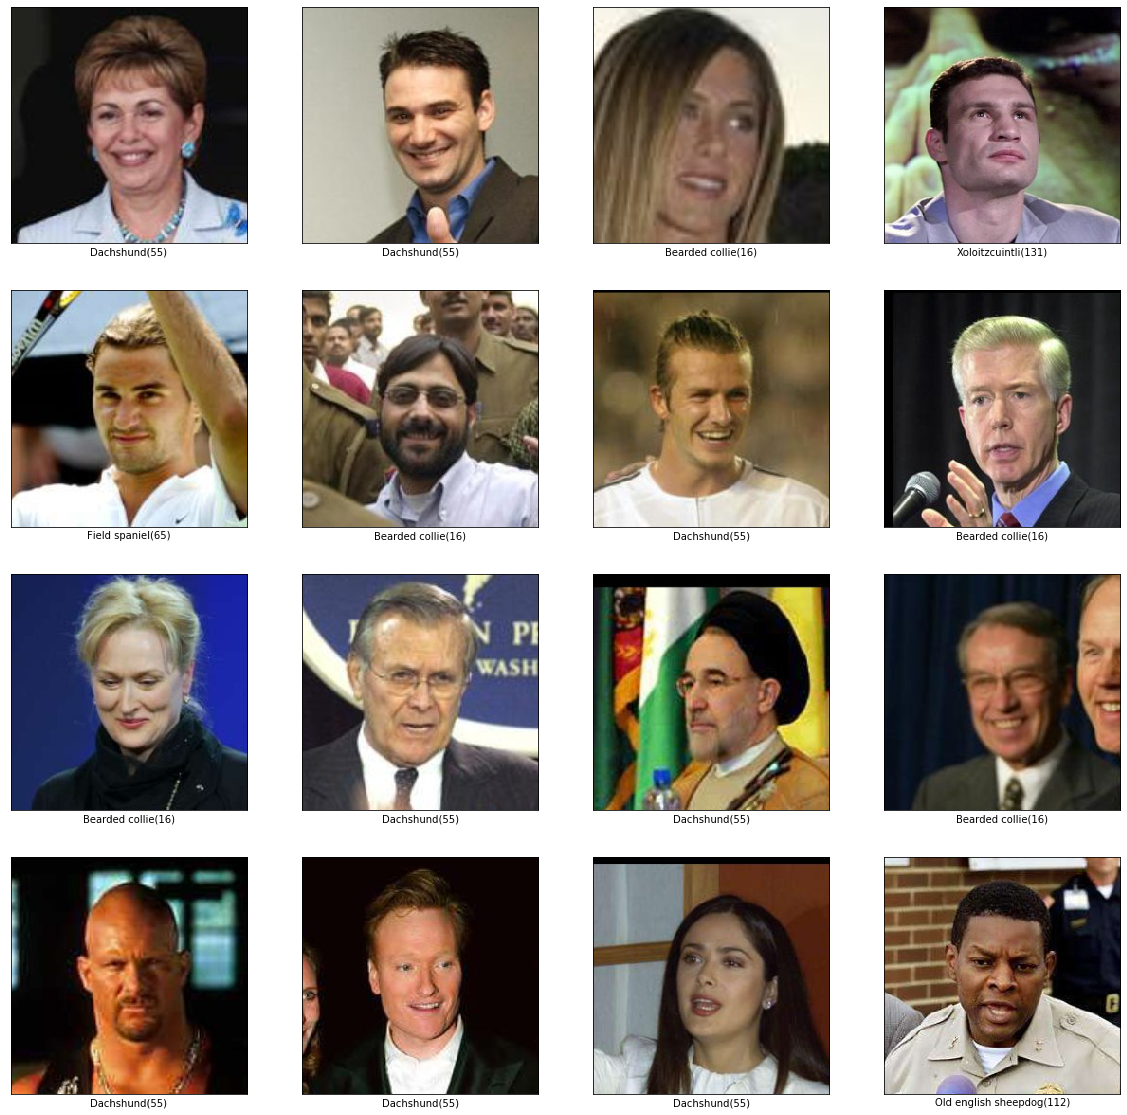

In [73]:
import random
human_files_short = random.sample(list(human_files), 100)

# Pick randomly 4 images from the set and test the predictions
fig = plt.figure(figsize=(20, 20))
plot_size=16
img = random.sample(list(human_files_short), plot_size)
for idx in np.arange(plot_size):
    ax = fig.add_subplot(4, plot_size/4, idx+1, xticks=[], yticks=[])
    predicted_breed = predict_breed_transfer(img[idx])
    plt.xlabel("{}({})".format(class_names[int(predicted_breed)], predicted_breed))
    plt.imshow(Image.open(img[idx]))